<h1><font size = 5><center> USA Restaurant Mania</center></font></h1>
<a><img src = "https://santabarbaraca.com/content/uploads/2015/08/restaurants-santa-barbara.jpg" height="10" width="1000", align = "center"></a>

# Introduction:

When a business is thinking about creating either a new chain of restaurants or adding more locations of an existing chain, it is a great strategic idea to know the lay of the land already for a given city or groups of cities. Knowledge on what types of restaurants are already present and the frequency of those in general is a key factor in making a decision. Additionally, understanding any patterns or relationships between the cities could help drive smart decisions on either which cuisines the company wants to introduce to those cities or which cuisines they should focus on for those closely related cities.



# Business Plan

The top 300 USA cities are listed on Wikipedia. However, it does not include the restaurant venue information along with any additional analytics such as the most common cuisines for each city. Further, one cannot easily see any relationships at all between the cities. If this information was available, the company could make more objective and informed decisions on where to create additional restaurants and what type of cuisines they should offer and serve. 

The main purpose of this project is to create the dataset described above. First, a dataset will be created by web scraping the top 300 USA cities with their respective locations. Next, another dataset will be created listing the closest 100 restaurants from the each city center (if available) by leveraging the coordinates. Finally, a common clustering algorithm will be used to visually show relationships between the cities based upon the most frequently available cuisine types based upon the information found. 

# Data Description

This section contains descriptions of the data that will be used to analyze the problem of determining where to create new restaurants and what type of cousine should be severed. 

### Data Sources:###

The data is to be collected from two main sources. 

**1. Top 300 USA Cities by Population:**

   First the table is extracted from the website [Top US Cities](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) by using a web scraping technique. This dataset includes the City name, the state, the population, the latitude and longitude coordinates. 


**2. 100 Closest Restaurants around each city:**

   In order to retrieve the closest named restaurants (up to 100) for each of the cities, the coordinates from the Top 300 USA Cities dataset are leveraged to trigger the Foursquare API for each city. The query is to bring back the results in a json file format. The results are then parsed further and reshaped in order to display the city, the restaurant name, type, and location for each data point. 
   
   
**3. Clustering Results:**

   The above dataset described as 100 Closest Restaurants around each city is massaged and manipulated further in such a way to create the top 10 most frequent types of restaurants for each city. This dataset is then used to perform the k-means clustering algorithm in order to generate a new dataset containing the cluster assignments that will be used to visually establish relationships between the cities based upon the top 10 most frequent restaurant types. The visual distribution is displayed by using the USA Map with different colored dots representing how the cities are related to one another based upon restaurant cuisine type distributions. The resulting clustering results dataset will contain the City name, the cluster it belongs to, and the top 10 restaurant types. Deeper analysis of this dataset will provide insight on both how similar each city is to one another and what the top 10 most frequent restaurant types there are within or around the city. 
   

# Python Code:

## Loading in the Libraries:

These are the required libraries to perform the analysis

In [365]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium # map rendering library
import random # library for random number generation
from IPython.display import Image 
from IPython.core.display import HTML 
from bs4 import BeautifulSoup #parser for JSON
import xml
import requests
import re #regular expression library
from mpl_toolkits.mplot3d import Axes3D
print('Libraries imported.')

Libraries imported.


## Top Cities in the USA Based Upon Population

### Goal: Create a Pandas Dataframe for the top USA cities

1. Retrieve the URL
2. Leveraging BeautifulSoup Library, find the table in the URL
3. Loop through every row of the table and extract out the Rank,City,State,Population
4. Create the Pandas dataframe

In [16]:
#scraping the URL
url = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population').text
soup = BeautifulSoup(url,'lxml')
table_class = {"class": ["sortable", "plainrowheaders"]}
wikitables = soup.find("table", table_class)
fields = wikitables.find_all('td')

#Defining some variables
rank = []
city = []
state = []
population = []
coord = []

#looping through the dataset appending to the variables
for i in range(0, len(fields), 11):
    rank.append(fields[i].text.strip())
    city.append(re.sub("[\[].*?[\]]", "", fields[i+1].text.strip()))
    state.append(re.sub("[\[].*?[\]]", "", fields[i+2].text.strip()))
    population.append(re.sub("[\[].*?[\]]", "", fields[i+3].text.strip()))
    coord.append(fields[i+10].findAll("span")[10].string)

# creating the pandas dataframe:        
df_uscity = pd.DataFrame(data=[rank,city,state,population,coord]).transpose()
df_uscity.columns = ['Rank', 'City', 'State','Population', 'Coordinates']
df_usloc = df_uscity['Coordinates'].str.split("; ", n=1, expand=True).astype(float)
result_tot = pd.concat([ df_uscity, df_usloc], axis=1, join='inner')
result_tot.columns = ['Rank', 'City', 'State','Population', 'Coordinates', 'Latitude', 'Longitude']
result_tot = result_tot.drop(['Coordinates'], axis=1)
result_tot.head()

,Rank,City,State,Population,Latitude,Longitude
0,1,New York City,New York,"8,398,748",40.6635,-73.9387
1,2,Los Angeles,California,"3,990,456",34.0194,-118.4108
2,3,Chicago,Illinois,"2,705,994",41.8376,-87.6818
3,4,Houston,Texas,"2,325,502",29.7866,-95.3909
4,5,Phoenix,Arizona,"1,660,272",33.5722,-112.0901


### Save the dataset to a file

In [17]:
result_tot.to_csv(r'USA_Total.csv')

## Map of the Top 300 USA Cities

### Goal: Create a Visual map of the USA with all of the cities located
1. Retrieve the latitdue and longitude coodinates of The United States using the foursquare agent
2. Create and intialize the USA map with the follium library and the coordinates from step 1
3. Loop through the Top 300 USA cities dataset adding a green dot to the map representing each city's location
4. Diplay the Map

In [18]:
#Finding the coordinates of the United States for the map visual
address = 'The United States'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of the United States using latitude and longitude values
map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)
# add markers to map
for lat, lng, city in zip(result_tot['Latitude'], result_tot['Longitude'], result_tot['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_USA)  
    
map_USA    

## Discovering the Restaurant distribution for each City
### Goal: Create a Pandas Dataframe with up to 100 closest restaurants for each city
1. Function that extracts the category for each venue using the FourSquare API
2. Looping through each city, leverage the FourSquare API to retrieve the closest 100 restaurants based upon the location
3. Create a Pandas Dataframe containing Rank,City,Population,Venue Name,Type,Latitude,Longitude

In [19]:
# function that extracts the category of the venue 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
#New empty Pandas Dataframe
USA_results_res = pd.DataFrame()
#looping through each city and retrieving the restaurants
for index, row in result_tot.iterrows():
    LIMIT = 500
    radius = 50000
    CLIENT_ID = '2M5DMGCBFEI5ILGOJR1KVQNZX5ZKZEPVPD1BZG2MT2UHG14T' # your Foursquare ID
    CLIENT_SECRET = 'BSHAHBWL3BRFQPZXBGH11OEJURNIARQ13PTT4R0HKBS0VVUG' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    url = 'https://api.foursquare.com/v2/venues/explore?query=\'Restaurant\'&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        row['Latitude'],
        row['Longitude'],
        radius,
        LIMIT)
    results_data = requests.get(url).json()
    venues = results_data['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues['City'] = row['City']
    nearby_venues['Population'] = row['Population']
    nearby_venues['Rank'] = row['Rank']
    nearby_venues['State'] = row['State']
    cols = ['Rank', 'City', 'State', 'Population', 'name', 'categories', 'lat', 'lng']
    nearby_venues = nearby_venues[cols]
    nearby_venues.columns = ['Rank', 'City', 'State', 'Population', 'Venue Name', 'Type', 'Latitude', 'Longitude']
    USA_results_res = USA_results_res.append(nearby_venues) 

In [27]:
USA_results_res.head() 

,Rank,City,State,Population,Venue Name,Type,Latitude,Longitude
0,1,New York City,New York,"8,398,748",PLG Coffee House and Tavern,Café,40.660007,-73.953362
1,1,New York City,New York,"8,398,748",The Food Sermon,Caribbean Restaurant,40.664588,-73.953735
2,1,New York City,New York,"8,398,748",Barboncino,Pizza Place,40.672104,-73.957412
3,1,New York City,New York,"8,398,748",Hunky Dory,Bistro,40.673139,-73.957029
4,1,New York City,New York,"8,398,748",Silver Rice,Sushi Restaurant,40.674187,-73.957037


### Saving the dataset to a file
#### In general, the dataset above is difficult to get because of the API timing out

In [28]:
 USA_results_res.to_csv(r'USA_Results_Restaurants.csv')

## Exploring the Dataset more:
### Goal: Create a "Tidy" Dataset with the Xth most frequent Restaurant Types per City

#### Upon further review, there are a couple instances of the same city name in different states.

In [29]:
 USA_results_res.groupby('City').count()

,Rank,State,Population,Venue Name,Type,Latitude,Longitude
City,,,,,,,
Abilene,65,65,65,65,65,65,65
Akron,100,100,100,100,100,100,100
Albuquerque,100,100,100,100,100,100,100
Alexandria,100,100,100,100,100,100,100
Allen,100,100,100,100,100,100,100
Allentown,100,100,100,100,100,100,100
Amarillo,82,82,82,82,82,82,82
Anaheim,100,100,100,100,100,100,100
Anchorage,100,100,100,100,100,100,100


#### Creating a City, State Column labeled "Address"

In [30]:
source_col_loc = USA_results_res.columns.get_loc('City') # column position starts from 0
source_col_loc
USA_results_res['Address'] = USA_results_res.iloc[:,source_col_loc:source_col_loc+2].apply(
    lambda x: ", ".join(x.astype(str)), axis=1)
USA_results_res.head()

,Rank,City,State,Population,Venue Name,Type,Latitude,Longitude,Address
0,1,New York City,New York,"8,398,748",PLG Coffee House and Tavern,Café,40.660007,-73.953362,"New York City, New York"
1,1,New York City,New York,"8,398,748",The Food Sermon,Caribbean Restaurant,40.664588,-73.953735,"New York City, New York"
2,1,New York City,New York,"8,398,748",Barboncino,Pizza Place,40.672104,-73.957412,"New York City, New York"
3,1,New York City,New York,"8,398,748",Hunky Dory,Bistro,40.673139,-73.957029,"New York City, New York"
4,1,New York City,New York,"8,398,748",Silver Rice,Sushi Restaurant,40.674187,-73.957037,"New York City, New York"


#### Check the Distribution again

In [31]:
 USA_results_res.groupby('Address').count()

,Rank,City,State,Population,Venue Name,Type,Latitude,Longitude
Address,,,,,,,,
"Abilene, Texas",65,65,65,65,65,65,65,65
"Akron, Ohio",100,100,100,100,100,100,100,100
"Albuquerque, New Mexico",100,100,100,100,100,100,100,100
"Alexandria, Virginia",100,100,100,100,100,100,100,100
"Allen, Texas",100,100,100,100,100,100,100,100
"Allentown, Pennsylvania",100,100,100,100,100,100,100,100
"Amarillo, Texas",82,82,82,82,82,82,82,82
"Anaheim, California",100,100,100,100,100,100,100,100
"Anchorage, Alaska",100,100,100,100,100,100,100,100


#### How many unique restaurant types are there ...

In [32]:
print('There are {} uniques restaurant types.'.format(len(USA_results_res['Type'].unique())))

There are 129 uniques restaurant types.


#### Checking the distribution of the restaurants overall

In [68]:
Type = USA_results_res.groupby('Type').count()
Type = Type.drop(['City', 'State','Population', 'Venue Name', 'Latitude', 'Longitude', 'Address'], axis=1)
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type.head(25)

,Count
Type,
Pizza Place,2673
American Restaurant,2475
Mexican Restaurant,2416
Italian Restaurant,1523
Sandwich Place,1481
Burger Joint,1373
Bakery,1219
Seafood Restaurant,1090
Café,997


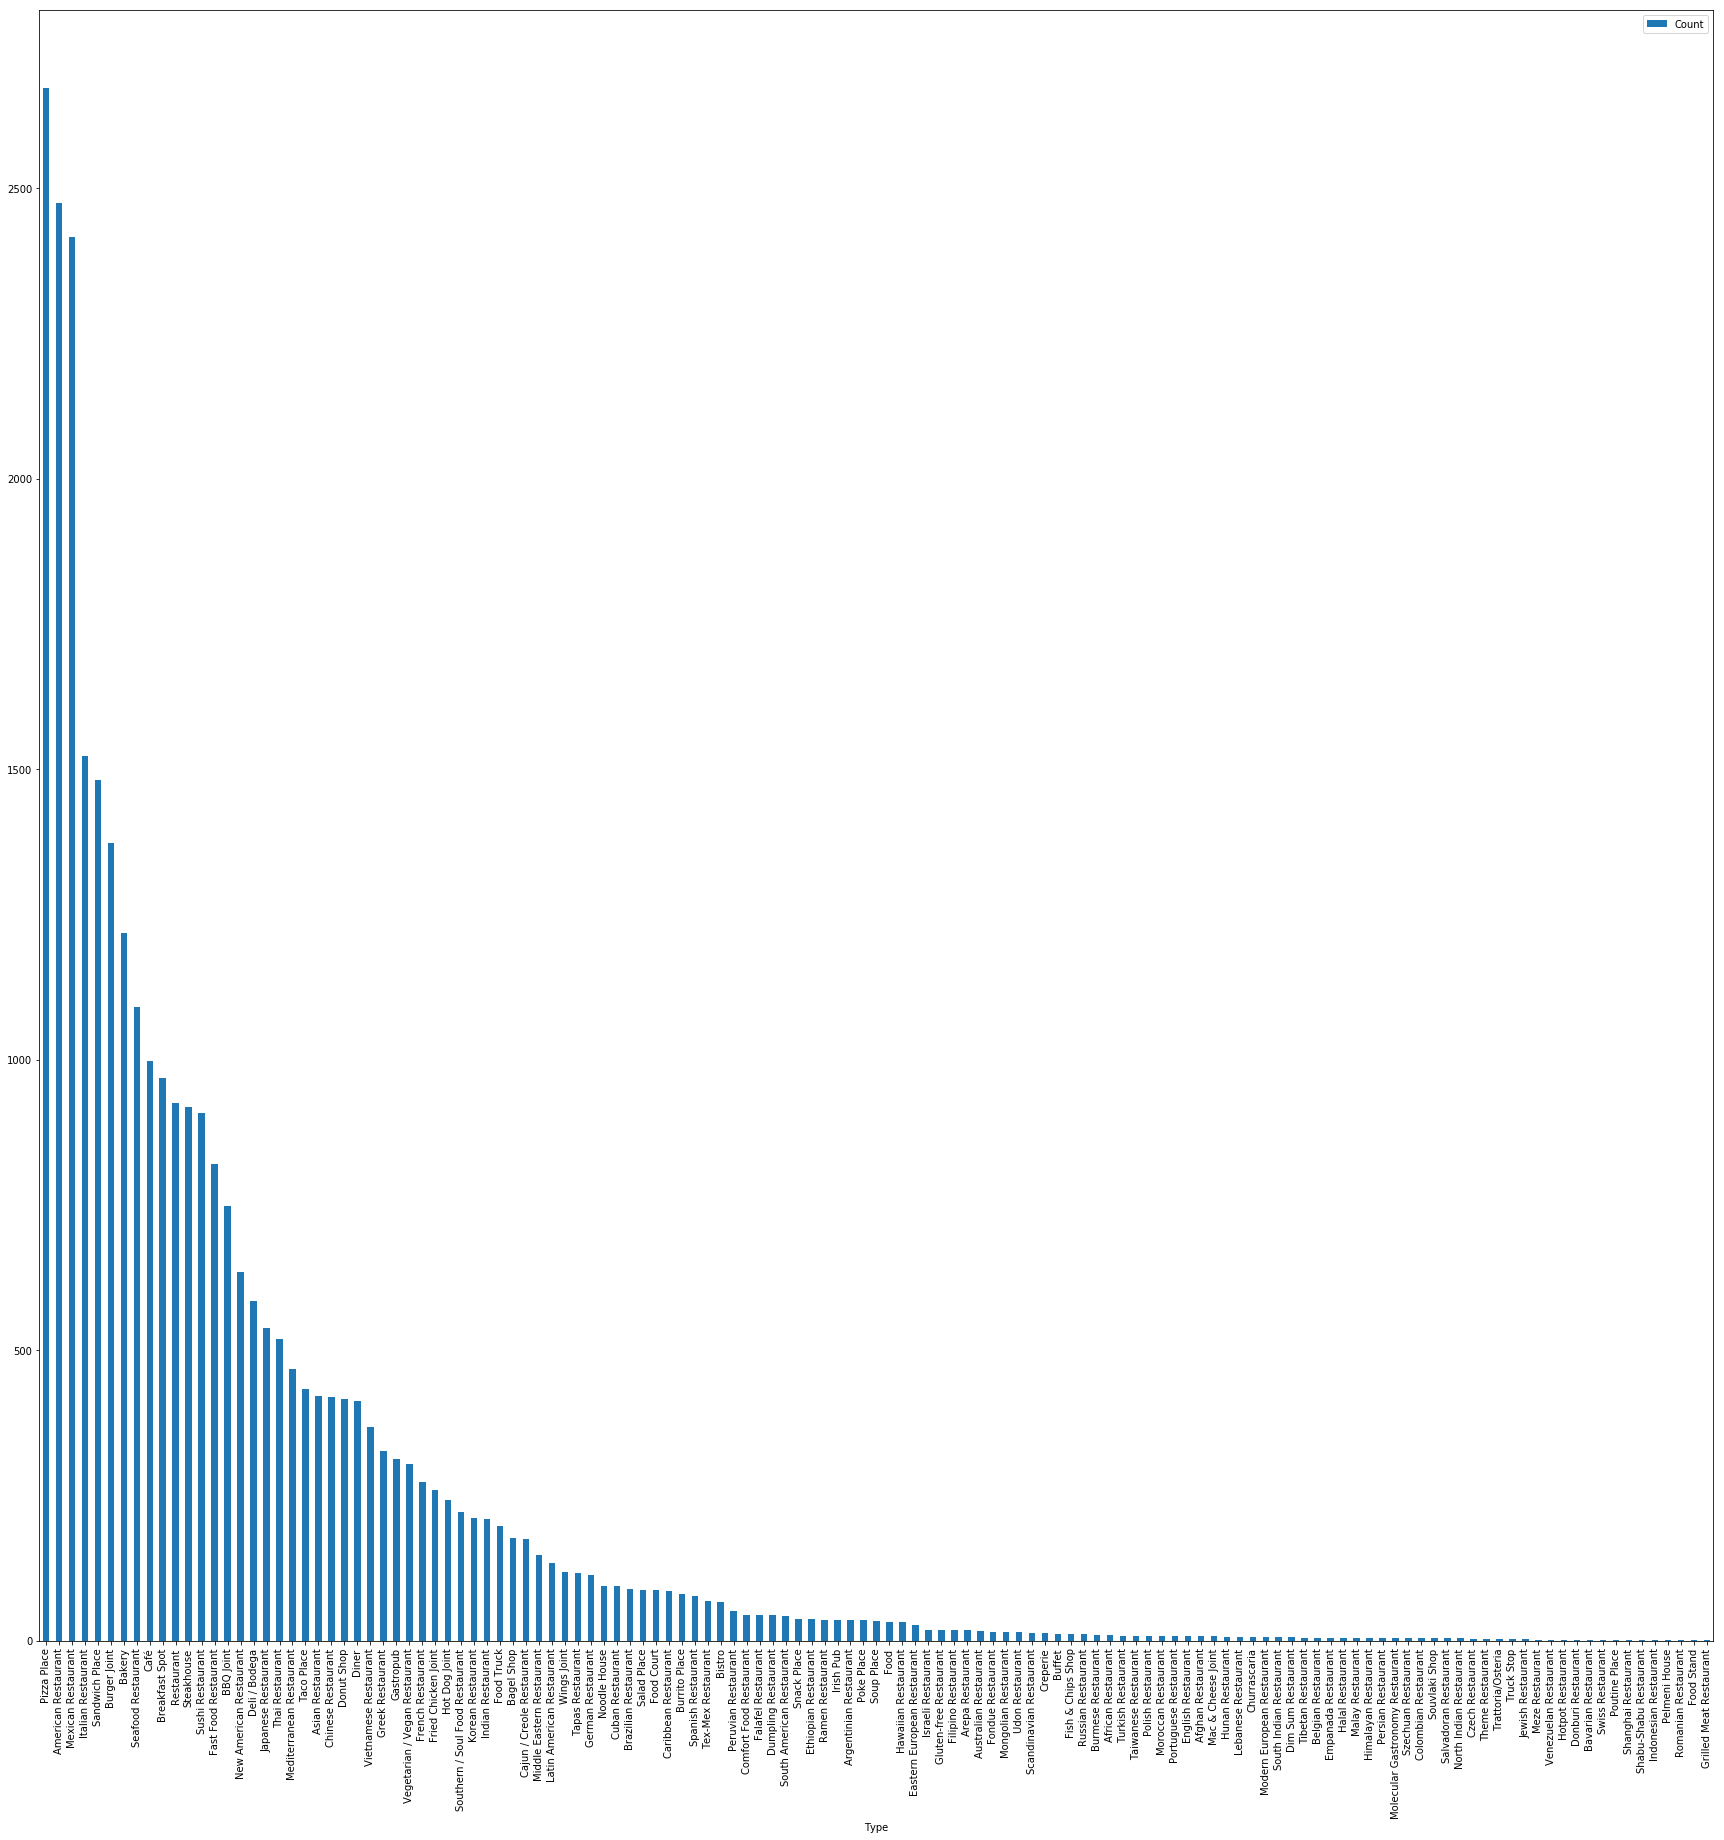

In [71]:
plt.rcParams['figure.figsize'] = [30, 30]
Type.plot.bar()

#### Dropping the row if the Type is just 'Restaurant'

In [78]:
USA_results_res = USA_results_res[USA_results_res.Type != 'Restaurant']

In [79]:
Type = USA_results_res.groupby('Type').count()
Type = Type.drop(['City', 'State','Population', 'Venue Name', 'Latitude', 'Longitude', 'Address'], axis=1)
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type.head(25)

,Count
Type,
Pizza Place,2673
American Restaurant,2475
Mexican Restaurant,2416
Italian Restaurant,1523
Sandwich Place,1481
Burger Joint,1373
Bakery,1219
Seafood Restaurant,1090
Café,997


#### One Hot encoding to obtain Type frequency for each city

In [317]:
# one hot encoding
USA_Total_Restaurant_onehot = pd.get_dummies(USA_results_res[['Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
USA_Total_Restaurant_onehot['Address'] = USA_results_res['Address'] 

# move neighborhood column to the first column
fixed_columns = [USA_Total_Restaurant_onehot.columns[-1]] + list(USA_Total_Restaurant_onehot.columns[:-1])
USA_Total_Restaurant_onehot = USA_Total_Restaurant_onehot[fixed_columns]
USA_Total_Restaurant_onehot_grouped = USA_Total_Restaurant_onehot.groupby('Address').mean().reset_index()
USA_Total_Restaurant_onehot_grouped.head()

,Address,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bavarian Restaurant,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pelmeni House,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Truck Stop,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abilene, Texas",0.000000,0.0,0.177419,0.0,0.0,0.000000,0.0,0.032258,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.064516,0.0,0.0,0.000000,0.000000,0.000000,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.080645,0.0,0.000000,0.0,0.016129,0.0,0.0,0.0,0.0,0.000000,0.000000,0.096774,0.0,0.0,0.0,0.016129,0.000000,0.0,0.000000,0.000000,0.016129,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.016129,0.016129,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.129032,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.080645,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.048387,0.0,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.064516,0.000000,0.0,0.0,0.000000,0.0,0.0,0.048387,0.016129,0.0,0.0,0.0,0.016129,0.0,0.0,0.000000,0.0,0.000000,0.016129
1,"Akron, Ohio",0.000000,0.0,0.141414,0.0,0.0,0.010101,0.0,0.000000,0.020202,0.030303,0.0,0.0,0.000000,0.000000,0.020202,0.0,0.090909,0.0,0.0,0.020202,0.010101,0.000000,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.020202,0.0,0.020202,0.0,0.020202,0.0,0.0,0.0,0.0,0.000000,0.000000,0.030303,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.030303,0.000000,0.0,0.010101,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.060606,0.020202,0.0,0.000000,0.000000,0.0,0.0,0.0,0.030303,0.090909,0.0,0.050505,0.0,0.0,0.000000,0.0,0.010101,0.000000,0.0,0.0,0.0,0.000000,0.050505,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.050505,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.020202,0.040404,0.0,0.0,0.010101,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.030303
2,"Albuquerque, New Mexico",0.000000,0.0,0.080808,0.0,0.

#### Deciding to keep the Top 25 events per city.

In [81]:
num_top_venues = 25
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating Top 25 Restaurant Types per City Dataset

In [319]:
num_top_venues = 25
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
USA_Restaurants_sorted = pd.DataFrame(columns=columns)
USA_Restaurants_sorted['Address'] = USA_Total_Restaurant_onehot_grouped['Address']

for ind in np.arange(USA_Total_Restaurant_onehot_grouped.shape[0]):
    USA_Restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(USA_Total_Restaurant_onehot_grouped.iloc[ind, :], num_top_venues)

USA_Restaurants_sorted.head()

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,"Abilene, Texas",American Restaurant,Mexican Restaurant,Fast Food Restaurant,Deli / Bodega,Pizza Place,Burger Joint,Steakhouse,Sandwich Place,Tex-Mex Restaurant,Chinese Restaurant,BBQ Joint,Wings Joint,Fried Chicken Joint,Seafood Restaurant,Food,Donut Shop,Truck Stop,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Grilled Meat Restaurant,Dumpling Restaurant,Eastern European Restaurant,Hawaiian Restaurant,Empanada Restaurant
1,"Akron, Ohio",American Restaurant,Mexican Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Sushi Restaurant,Wings Joint,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Bakery,Mediterranean Restaurant,Gastropub,Donut Shop,Diner,Japanese Restaurant,Café,Deli / Bodega,Steakhouse,Breakfast Spot,Bagel Shop,New American Restaurant,Cajun / Creole Restaurant
2,"Albuquerque, New Mexico",Mexican Restaurant,Pizza Place,American Restaurant,Sandwich Place,Burger Joint,Café,Steakhouse,Sushi Restaurant,Breakfast Spot,BBQ Joint,Vietnamese Restaurant,Italian Restaurant,Bagel Shop,Thai Restaurant,Asian Restaurant,Donut Shop,Middle Eastern Restaurant,Fast Food Restaurant,Salad Place,Japanese Restaurant,Diner,Caribbean Restaurant,New American Restaurant,Seafood Restaurant,Peruvian Restaurant
3,"Alexandria, Virginia",American Restaurant,Pizza Place,Italian Restaurant,Taco Place,Mediterranean Restaurant,Thai Restaurant,Seafood Restaurant,New American Restaurant,French Restaurant,Indian Restaurant,Food Truck,Sandwich Place,BBQ Joint,Donut Shop,Burger Joint,Asian Restaurant,Spanish Restaurant,Sushi Restaurant,Chinese Restaurant,Salad Place,Ramen Restaurant,Café,Bakery,Middle Eastern Restaurant,Deli / Bodega
4,"Allen, Texas",American Restaurant,BBQ Joint,Pizza Place,Italian Restaurant,Steakhouse,Sushi Restaurant,Mexican Restaurant,Taco Place,Burger Joint,Seafood Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Café,New American Restaurant,Breakfast Spot,Greek Restaurant,Japanese Restaurant,Bakery,Thai Restaurant,Bistro,Food Court,Chinese Restaurant,Latin American Restaurant,Donut Shop,Diner


#### Saving Dataset to a file

In [123]:
USA_Restaurants_sorted.to_csv(r'USA_Restaurants_sorted.csv')

In [124]:
USA_Total_Restaurant_onehot_grouped.to_csv(r'USA_Total_Restaurant_onehot_grouped.csv')

## Clustering Analysis:
### Goal: Find the optimal number of cluster groups and visualize the groups

#### Seven clusters are determined the best by visual inspection

In [172]:
# set number of clusters
kclusters = 7
USA_Total_Restaurant_onehot_grouped
USA_Total_Restaurant_clustering = USA_Total_Restaurant_onehot_grouped.drop('Address', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(USA_Total_Restaurant_clustering)
C = kmeans.cluster_centers_
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:300] 

array([6, 6, 1, 3, 2, 0, 4, 5, 1, 0, 5, 2, 6, 1, 3, 1, 6, 6, 5, 1, 3, 2,
       1, 5, 5, 1, 0, 0, 3, 0, 0, 1, 4, 0, 5, 5, 3, 3, 2, 1, 6, 1, 0, 3,
       0, 1, 6, 2, 3, 0, 1, 3, 5, 0, 1, 1, 0, 0, 1, 1, 0, 5, 0, 1, 3, 3,
       2, 5, 6, 3, 0, 1, 6, 0, 0, 5, 1, 5, 3, 5, 1, 6, 5, 1, 3, 5, 1, 3,
       1, 1, 1, 1, 1, 3, 1, 1, 5, 1, 2, 5, 6, 3, 2, 0, 0, 5, 2, 1, 1, 6,
       1, 5, 6, 6, 5, 2, 3, 1, 5, 3, 5, 2, 3, 1, 6, 0, 2, 3, 2, 2, 6, 5,
       6, 1, 6, 6, 1, 5, 1, 6, 2, 0, 6, 3, 1, 0, 4, 4, 2, 1, 2, 6, 1, 1,
       5, 2, 1, 5, 4, 1, 0, 6, 1, 2, 2, 0, 0, 2, 3, 3, 4, 0, 0, 3, 3, 1,
       1, 1, 6, 6, 6, 0, 0, 2, 5, 5, 3, 6, 1, 0, 2, 5, 5, 0, 4, 2, 6, 0,
       1, 3, 0, 6, 1, 3, 1, 5, 1, 5, 2, 3, 1, 6, 0, 0, 0, 2, 5, 3, 3, 5,
       5, 1, 1, 2, 1, 1, 5, 1, 2, 5, 3, 1, 6, 5, 1, 1, 2, 1, 0, 1, 3, 5,
       4, 1, 1, 3, 3, 5, 5, 0, 3, 5, 5, 6, 6, 3, 0, 5, 2, 3, 1, 1, 6, 0,
       6, 0, 1, 0, 0, 0, 0, 1, 2, 5, 1, 0, 5, 0, 0, 6, 0, 6, 3, 0, 1, 2,
       1, 1, 1, 1, 1, 5, 5, 1, 1, 3, 1, 3, 1, 0])

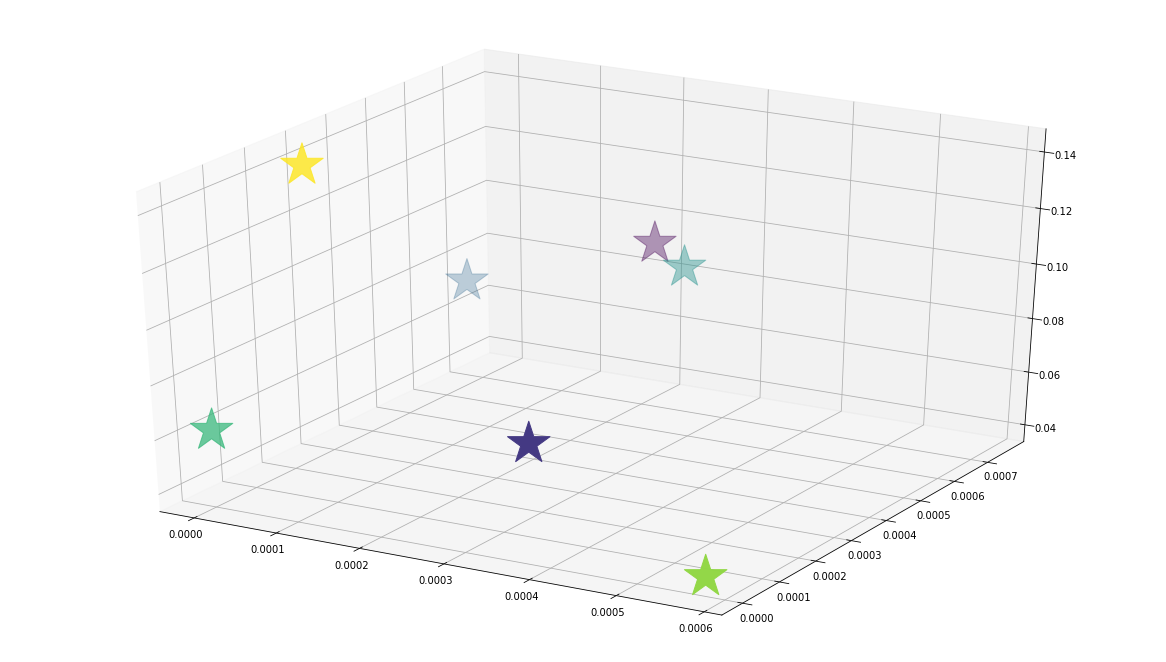

In [314]:
cm = plt.get_cmap("RdYlGn")
col = np.arange(7)
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=col, s=2000)

#### Adding the Cluster Labels

In [315]:
fig.savefig("Cluster_Distributions.jpg", dpi=300)

In [320]:
# add clustering labels
USA_Restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
USA_Clustered_Restaurants = result_tot
source_col_loc = USA_Clustered_Restaurants.columns.get_loc('City') # column position starts from 0
source_col_loc
USA_Clustered_Restaurants['Address'] = USA_Clustered_Restaurants.iloc[:,source_col_loc:source_col_loc+2].apply(
    lambda x: ", ".join(x.astype(str)), axis=1)
USA_Clustered_Restaurants = USA_Clustered_Restaurants.join(USA_Restaurants_sorted.set_index('Address'), on='Address')


In [321]:
USA_Clustered_Restaurants.head()

,Rank,City,State,Population,Latitude,Longitude,Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,1,New York City,New York,"8,398,748",40.6635,-73.9387,"New York City, New York",5,Pizza Place,Bakery,Italian Restaurant,Café,Donut Shop,Caribbean Restaurant,Sandwich Place,Japanese Restaurant,Seafood Restaurant,New American Restaurant,Breakfast Spot,Moroccan Restaurant,Greek Restaurant,American Restaurant,Latin American Restaurant,Thai Restaurant,Bagel Shop,Asian Restaurant,Food Court,Ethiopian Restaurant,Israeli Restaurant,Fried Chicken Joint,Salad Place,Deli / Bodega,Noodle House
1,2,Los Angeles,California,"3,990,456",34.0194,-118.4108,"Los Angeles, California",2,Sushi Restaurant,American Restaurant,Italian Restaurant,Café,Mexican Restaurant,New American Restaurant,Pizza Place,Japanese Restaurant,Steakhouse,Korean Restaurant,Sandwich Place,French Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,Poke Place,Salad Place,Food Truck,Australian Restaurant,Thai Restaurant,Fast Food Restaurant,Chinese Restaurant,Caribbean Restaurant,Cajun / Creole Restaurant,Burger Joint
2,3,Chicago,Illinois,"2,705,994",41.8376,-87.6818,"Chicago, Illinois",2,New American Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Donut Shop,American Restaurant,Japanese Restaurant,Steakhouse,Seafood Restaurant,Deli / Bodega,Mexican Restaurant,Burger Joint,Mediterranean Restaurant,Diner,Taco Place,Café,Gastropub,Chinese Restaurant,Breakfast Spot,Filipino Restaurant,Cuban Restaurant,Peruvian Restaurant,Molecular Gastronomy Restaurant,Snack Place,Food Court
3,4,Houston,Texas,"2,325,502",29.7866,-95.3909,"Houston, Texas",2,Mexican Restaurant,Burger Joint,Pizza Place,Café,American Restaurant,New American Restaurant,Taco Place,Italian Restaurant,Steakhouse,Vietnamese Restaurant,Food Truck,Seafood Restaurant,Sushi Restaurant,Fast Food Restaurant,BBQ Joint,French Restaurant,Japanese Restaurant,Deli / Bodega,Sandwich Place,Mediterranean Restaurant,Greek Restaurant,Chinese Restaurant,Salad Place,Noodle House,Cajun / Creole Restaurant
4,5,Phoenix,Arizona,"1,660,272",33.5722,-112.0901,"Phoenix, Arizona",0,Pizza Place,Burger Joint,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Café,Breakfast Spot,Sushi Restaurant,Sandwich Place,New American Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Gluten-free Restaurant,Seafood Restaurant,Asian Restaurant,Chinese Restaurant,Taco Place,Steakhouse,Thai Restaurant,BBQ Joint,Fried Chicken Joint,Fast Food Restaurant,Gastropub


#### Saving the Dataset

In [179]:
USA_Clustered_Restaurants.to_csv(r'USA_Clustered_Restaurants.csv')

#### Mapping the Clusters to the Visual Map

In [322]:
import matplotlib.cm as cm
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(USA_Clustered_Restaurants['Latitude'], USA_Clustered_Restaurants['Longitude'], USA_Clustered_Restaurants['City'], USA_Clustered_Restaurants['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [323]:
fig = map_clusters.save('Map_USA_Clustered_Restaurants.html')

## Cluster Zero Results:

In [343]:
Cluster_0 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 0, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_0_Address = Cluster_0.Address

In [344]:
Cluster_0_Results = pd.merge(USA_results_res, Cluster_0_Address, on = 'Address', how = 'inner')
Cluster_0_Results = Cluster_0_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)

In [345]:
Type = Cluster_0_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)

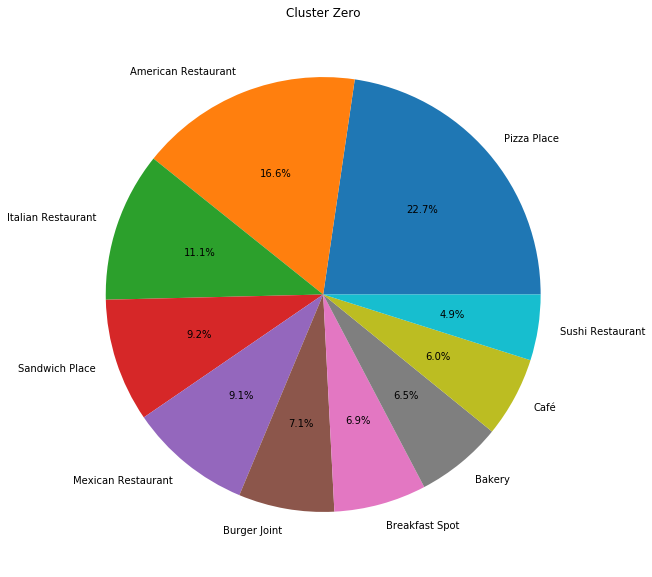

In [346]:
plot = Type.plot.pie(y = 'Count', title = 'Cluster Zero', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')

In [347]:
fig = plot.get_figure()
fig.savefig("cluster_zero.jpg", dpi=300)

In [348]:
Cluster_0_Cities = pd.merge(result_tot, Cluster_0_Address, on = 'Address', how = 'inner')
Cluster_0_Cities = Cluster_0_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_0_Cities.sort_values('State', inplace = True)
Cluster_0_Cities.reset_index(drop=True)

,City,State,Population,Latitude,Longitude
0,Birmingham,Alabama,"209,880",33.527400,-86.799000
1,Phoenix,Arizona,"1,660,272",33.572200,-112.090100
2,Tempe,Arizona,"192,364",33.388400,-111.931800
3,Glendale,Arizona,"250,702",33.533100,-112.189900
4,Scottsdale,Arizona,"255,310",33.684300,-111.861100
5,Chandler,Arizona,"257,165",33.282900,-111.854900
6,Mesa,Arizona,"508,958",33.401900,-111.717400
7,Gilbert,Arizona,"248,279",33.310300,-111.743100
8,Oceanside,California,"176,080",33.224500,-117.306200
9,Boulder,Colorado,"107,353",40.027000,-105.251900


In [349]:
Cluster_0_Cities.to_csv(r'Cluster_0_Results_Restaurants.csv')

## Cluster One Results:

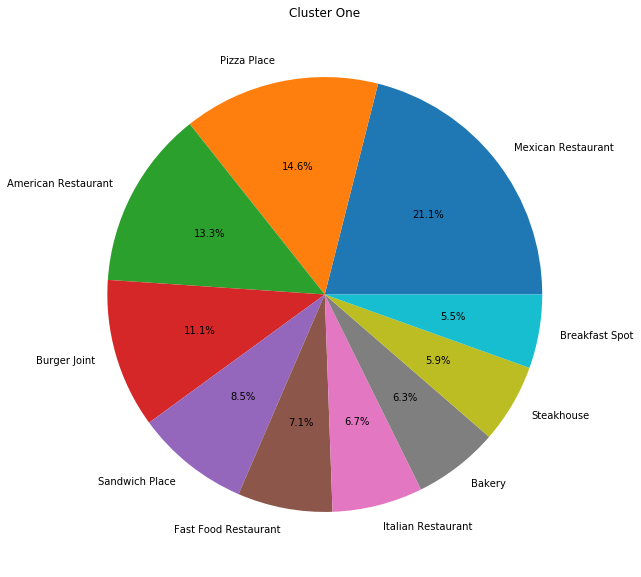

In [350]:
Cluster_1 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 1, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_1_Address = Cluster_1.Address
Cluster_1_Results = pd.merge(USA_results_res, Cluster_1_Address, on = 'Address', how = 'inner')
Cluster_1_Results = Cluster_1_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)
  
Type = Cluster_1_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)
plot = Type.plot.pie(y = 'Count', title = 'Cluster One', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')


In [351]:
fig = plot.get_figure()
fig.savefig("cluster_one.jpg", dpi=300)

In [352]:
Cluster_1_Cities = pd.merge(result_tot, Cluster_1_Address, on = 'Address', how = 'inner')
Cluster_1_Cities = Cluster_1_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_1_Cities.sort_values('State', inplace = True)
Cluster_1_Cities.reset_index(drop=True)

,City,State,Population,Latitude,Longitude
0,Tuscaloosa,Alabama,"101,113",33.2065,-87.5346
1,Montgomery,Alabama,"198,218",32.3472,-86.2661
2,Huntsville,Alabama,"197,318",34.6990,-86.6730
3,Anchorage,Alaska,"291,538",61.1743,-149.2843
4,Surprise,Arizona,"138,161",33.6706,-112.4527
5,Tucson,Arizona,"545,975",32.1531,-110.8706
6,Peoria,Arizona,"172,259",33.7862,-112.3080
7,Little Rock,Arkansas,"197,881",34.7254,-92.3586
8,Vacaville,California,"100,154",38.3539,-121.9728
9,Roseville,California,"139,117",38.7690,-121.3189


In [353]:
Cluster_1_Cities.to_csv(r'Cluster_1_Results_Restaurants.csv')

## Cluster 2 Results:

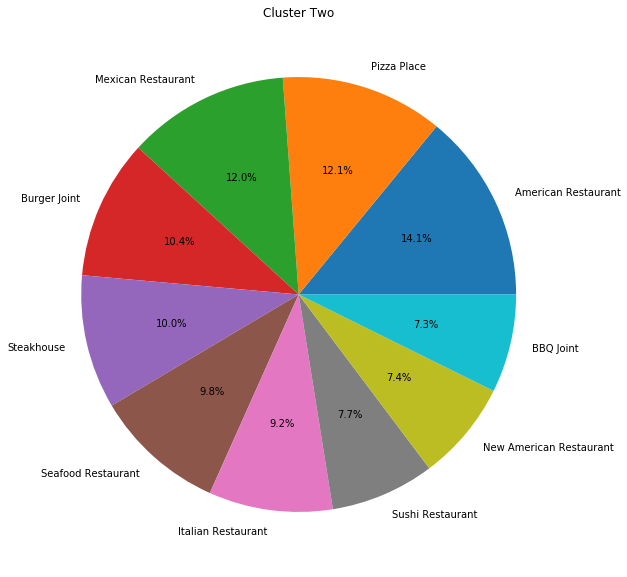

In [356]:
Cluster_2 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 2, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_2_Address = Cluster_2.Address
Cluster_2_Results = pd.merge(USA_results_res, Cluster_2_Address, on = 'Address', how = 'inner')
Cluster_2_Results = Cluster_2_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)
Type = Cluster_2_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)
plot = Type.plot.pie(y = 'Count', title = 'Cluster Two', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')

In [358]:
fig = plot.get_figure()
fig.savefig("cluster_two.jpg", dpi=300)

In [357]:
Cluster_2_Cities = pd.merge(result_tot, Cluster_2_Address, on = 'Address', how = 'inner')
Cluster_2_Cities = Cluster_2_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_2_Cities.sort_values('State', inplace = True)
Cluster_2_Cities.reset_index(drop=True)
Cluster_2_Cities.to_csv(r'Cluster_2_Results_Restaurants.csv')

## Cluster 3 Results:

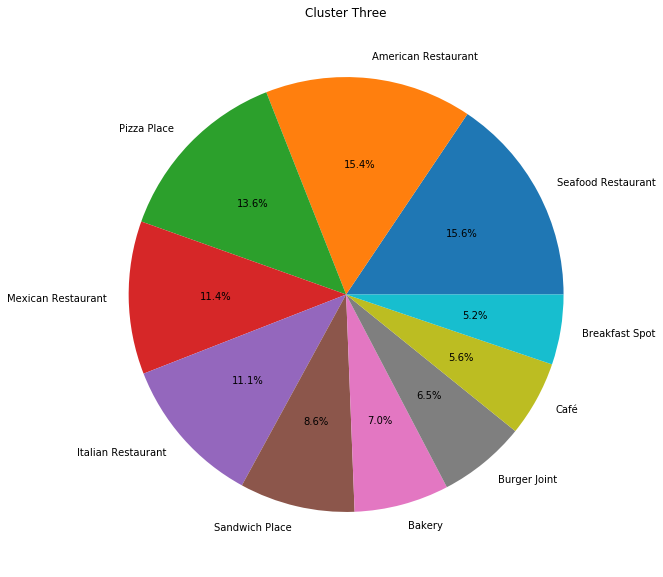

In [360]:
Cluster_3 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 3, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_3_Address = Cluster_3.Address
Cluster_3_Results = pd.merge(USA_results_res, Cluster_3_Address, on = 'Address', how = 'inner')
Cluster_3_Results = Cluster_3_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)
Type = Cluster_3_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)
plot = Type.plot.pie(y = 'Count', title = 'Cluster Three', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')

fig = plot.get_figure()
fig.savefig("cluster_three.jpg", dpi=300)

Cluster_3_Cities = pd.merge(result_tot, Cluster_3_Address, on = 'Address', how = 'inner')
Cluster_3_Cities = Cluster_3_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_3_Cities.sort_values('State', inplace = True)
Cluster_3_Cities.reset_index(drop=True)
Cluster_3_Cities.to_csv(r'Cluster_3_Results_Restaurants.csv')

## Cluster 4 Results:

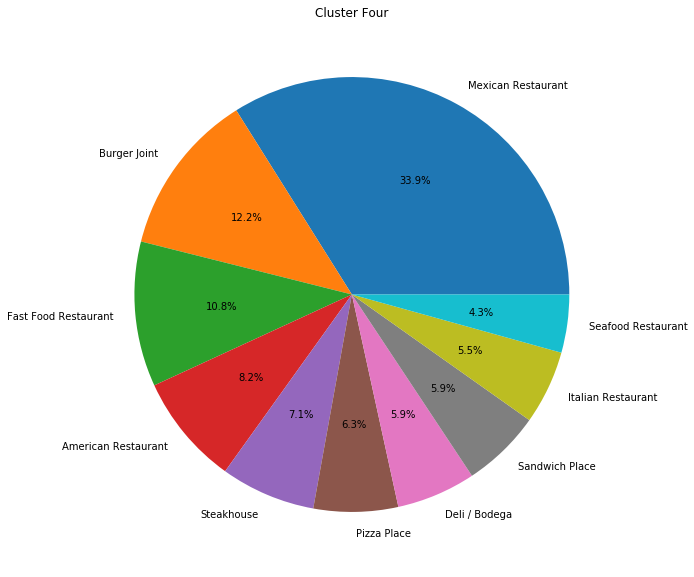

In [361]:
Cluster_4 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 4, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_4_Address = Cluster_4.Address
Cluster_4_Results = pd.merge(USA_results_res, Cluster_4_Address, on = 'Address', how = 'inner')
Cluster_4_Results = Cluster_4_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)
Type = Cluster_4_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)
plot = Type.plot.pie(y = 'Count', title = 'Cluster Four', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')

fig = plot.get_figure()
fig.savefig("cluster_four.jpg", dpi=300)

Cluster_4_Cities = pd.merge(result_tot, Cluster_4_Address, on = 'Address', how = 'inner')
Cluster_4_Cities = Cluster_4_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_4_Cities.sort_values('State', inplace = True)
Cluster_4_Cities.reset_index(drop=True)
Cluster_4_Cities.to_csv(r'Cluster_4_Results_Restaurants.csv')

## Cluster 5 Results:

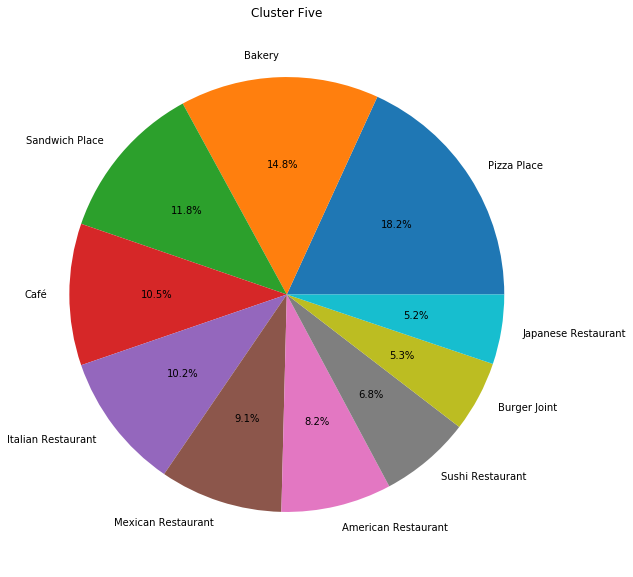

In [363]:
Cluster_5 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 5, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_5_Address = Cluster_5.Address
Cluster_5_Results = pd.merge(USA_results_res, Cluster_5_Address, on = 'Address', how = 'inner')
Cluster_5_Results = Cluster_5_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)
Type = Cluster_5_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)
plot = Type.plot.pie(y = 'Count', title = 'Cluster Five', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')

fig = plot.get_figure()
fig.savefig("cluster_five.jpg", dpi=300)

Cluster_5_Cities = pd.merge(result_tot, Cluster_5_Address, on = 'Address', how = 'inner')
Cluster_5_Cities = Cluster_5_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_5_Cities.sort_values('State', inplace = True)
Cluster_5_Cities.reset_index(drop=True)
Cluster_5_Cities.to_csv(r'Cluster_5_Results_Restaurants.csv')

## Cluster 6 Results:

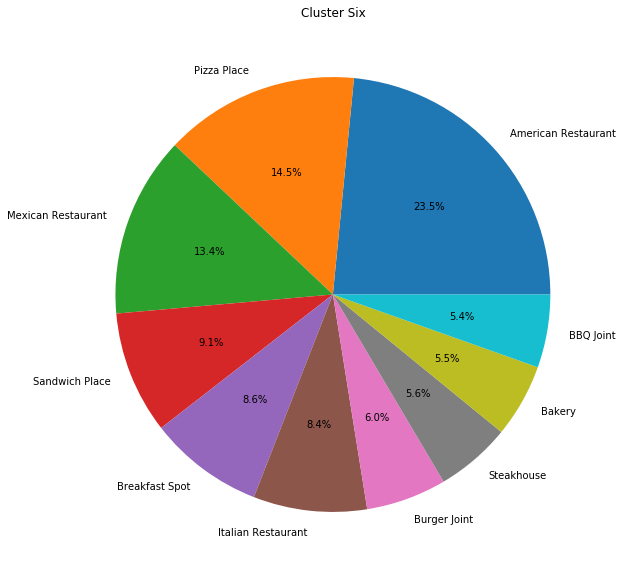

In [364]:
Cluster_6 = USA_Clustered_Restaurants.loc[USA_Clustered_Restaurants['Cluster Labels'] == 6, 
                                          USA_Clustered_Restaurants.columns[[1] + list(range(5, USA_Clustered_Restaurants.shape[1]))]]
Cluster_6_Address = Cluster_6.Address
Cluster_6_Results = pd.merge(USA_results_res, Cluster_6_Address, on = 'Address', how = 'inner')
Cluster_6_Results = Cluster_6_Results.drop(['Rank', 'City', 'State', 'Population', 'Venue Name',
                                           'Latitude', 'Longitude'], axis=1)
Type = Cluster_6_Results.groupby('Type').count()
Type.columns = ['Count']
Type.sort_values('Count', ascending=False, inplace=True)
Type = Type.head(10)
plot = Type.plot.pie(y = 'Count', title = 'Cluster Six', legend = False, label='', figsize=(10, 10), autopct='%1.1f%%')

fig = plot.get_figure()
fig.savefig("cluster_six.jpg", dpi=300)

Cluster_6_Cities = pd.merge(result_tot, Cluster_6_Address, on = 'Address', how = 'inner')
Cluster_6_Cities = Cluster_6_Cities.drop(['Rank', 'Address'], axis=1)
Cluster_6_Cities.sort_values('State', inplace = True)
Cluster_6_Cities.reset_index(drop=True)
Cluster_6_Cities.to_csv(r'Cluster_6_Results_Restaurants.csv')